In [97]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [98]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

/home/mrjohn/.conda/envs/mathML/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [99]:
mnist.data.shape

(70000, 784)

In [100]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X = X[:10000]
y = y[:10000]
X.shape

(10000, 784)

In [101]:
X /= 255.0

In [102]:
def plot_example(X, y, idx=0):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[idx:idx+5].reshape(5, 28, 28), y[idx:idx+5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

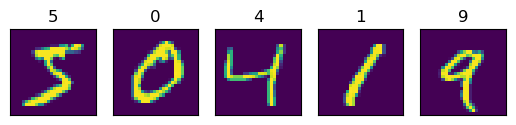

In [103]:
plot_example(X, y)

In [104]:
# %%timeit -n 1 -r 1

# These are separate try/except blocks so that if the QR decomposition succeeds
# but the SVD fails, we don't have to recompute the QR decomposition.
# try:
#     Q = np.load('Q.npy')
#     R = np.load('R.npy')
# except OSError:
Q, R = linalg.qr(X)
np.save('Q.npy', Q)
np.save('R.npy', R)

# try:
#     U = np.load('U.npy')
#     s = np.load('s.npy')
#     Vh = np.load('Vh.npy')
# except OSError:
U, s, Vh = linalg.svd(R)
# U, s, Vh = linalg.svd(X)
np.save('U.npy', U)
np.save('s.npy', s)
np.save('Vh.npy', Vh)

print(Q.shape, R.shape, U.shape, s.shape, Vh.shape)

(10000, 10000) (10000, 784) (10000, 10000) (784,) (784, 784)


In [105]:
# Only have to run this once, the svd is very slow for such a big matrix
# Save the results and set load=True to load them
# load = True

# if load:
#     U = np.load('U.npy')
#     s = np.load('s.npy')
#     Vh = np.load('Vh.npy')
# else:
#     U, s, Vh = linalg.svd(X)
#     np.save('U.npy', U)
#     np.save('s.npy', s)
#     np.save('Vh.npy', Vh)

Text(0.5, 1.0, 'Singular Values')

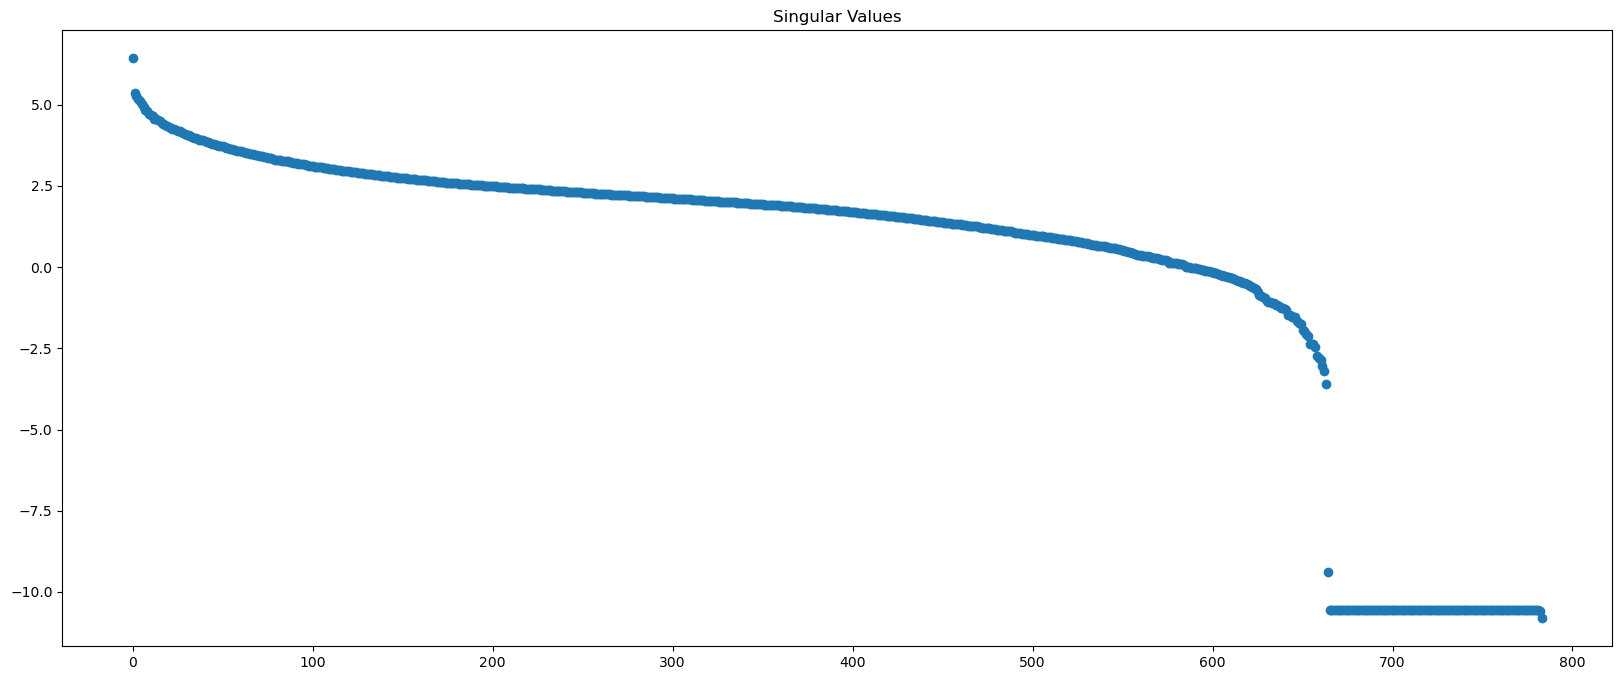

In [12]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,784), np.log(s))
plt.title('Singular Values')

## Recentering by Bounding Box

In [13]:
# modified code, original source: https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def find_bbox(img):
    img = np.where(img>0.3, img, 0)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax+1, cmin, cmax+1

10000it [00:01, 6538.53it/s]


7 27 8 21
(17, 14)
recentered shape (28, 28)


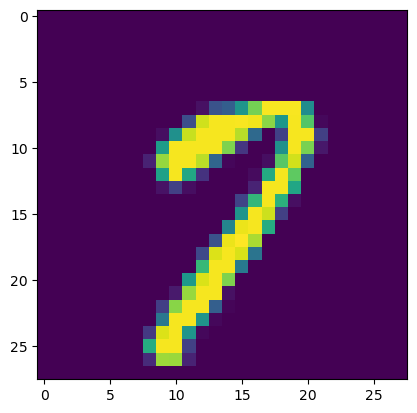

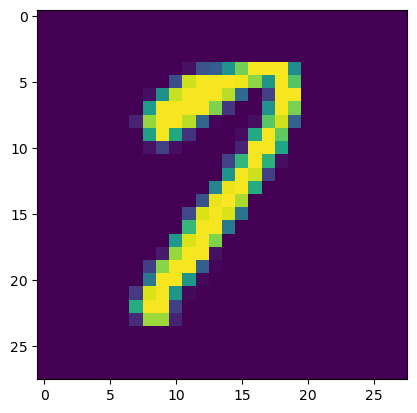

In [14]:
from tqdm import tqdm

X_recentered = np.zeros_like(X)

for i, img in tqdm(enumerate(X)):
    img = img.reshape(28,28)
    rmin, rmax, cmin, cmax = find_bbox(img)
    bbox_center = ((rmin + rmax)//2,  (cmin + cmax)//2)
    
    bbox_img = img[rmin:rmax, cmin:cmax]

    padr1 = padr2 = (28-(rmax-rmin))//2
    padc1 = padc2 = (28-(cmax-cmin))//2

    if (rmax+rmin)%2 == 1:
        padr2 += 1
    if (cmax+cmin)%2 == 1:
        padc2 += 1

    recentered_img = np.pad(bbox_img, ((padr1, padr2), (padc1, padc2)))
    X_recentered[i] = recentered_img.flatten()

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(recentered_img)

print(rmin, rmax, cmin, cmax)
print(bbox_center)
print('recentered shape', recentered_img.shape)

In [15]:
Q_rec, R_rec = linalg.qr(X_recentered)
U_rec, s_rec, Vh_rec = linalg.svd(R_rec)

s_rec.shape

(784,)

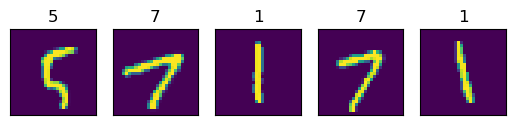

In [16]:
plot_example(X, y, idx=100)

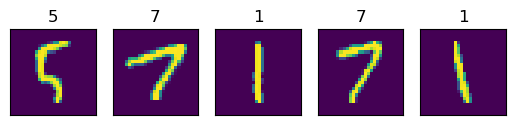

In [17]:
plot_example(X_recentered, y, idx=100)

Text(0.5, 1.0, 'Singular Values After Recentering')

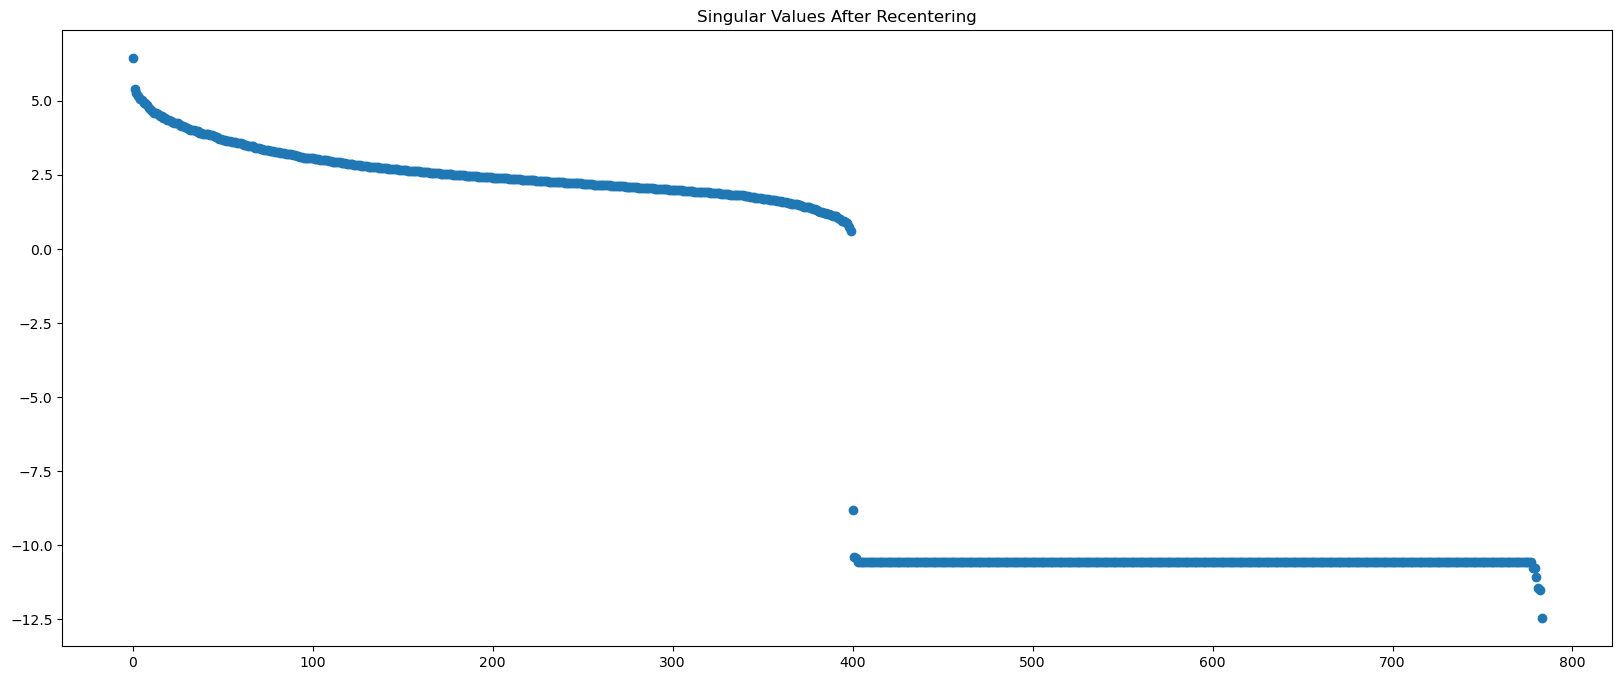

In [18]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,784), np.log(s_rec))
plt.title('Singular Values After Recentering')

## Split by class

In [19]:
digits = {}
si_list = []

for i in range(10):
    digits[i] = X[y==i]

In [20]:
for i in range(10):
    print(digits[i].shape)
    Qi, Ri = linalg.qr(digits[i])
    Ui, si, Vhi = linalg.svd(Ri)
    si_list.append(si)

(1001, 784)
(1127, 784)
(991, 784)
(1032, 784)
(980, 784)
(863, 784)
(1014, 784)
(1070, 784)
(944, 784)
(978, 784)


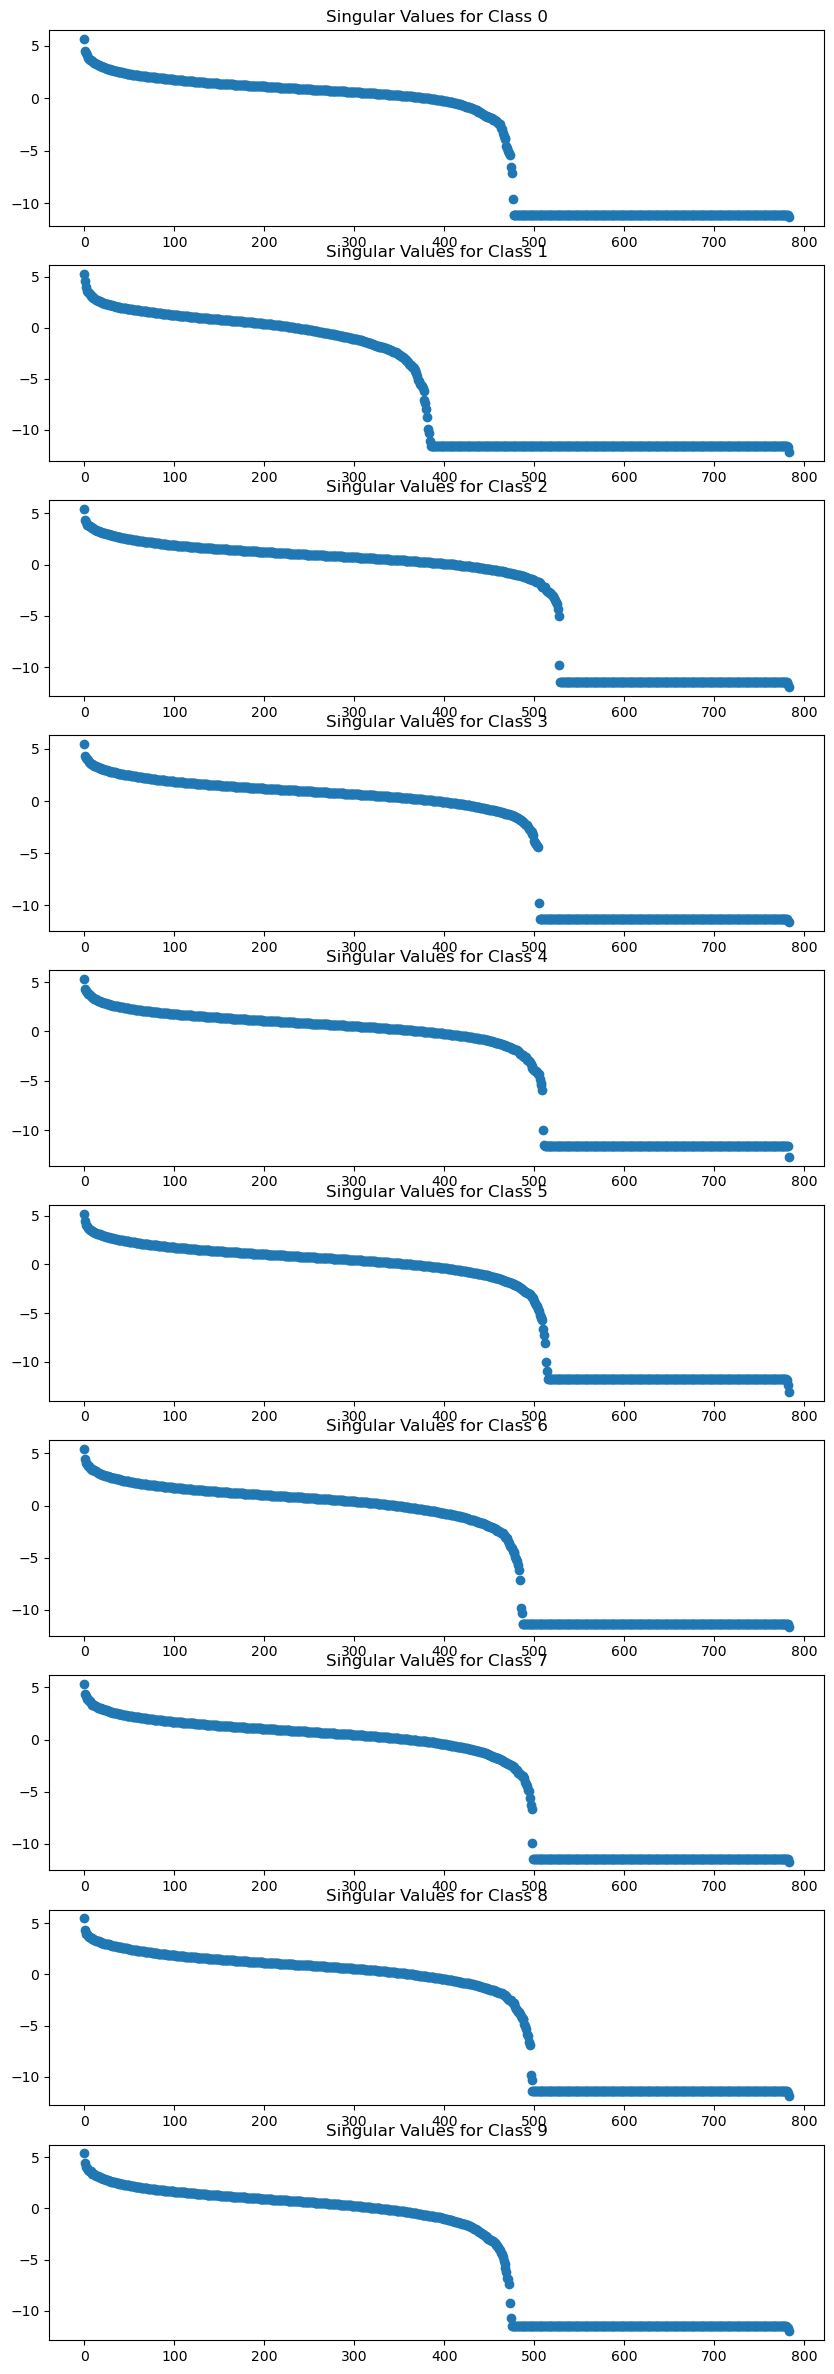

In [21]:
fig, ax = plt.subplots(10, 1, figsize=(10,30))

for i in range(10):
    ax[i].scatter(np.arange(0,784), np.log(si_list[i]))
    ax[i].set_title(f'Singular Values for Class {i}')

### By class and recentered

In [22]:
digits_rec = {}
si_rec_list = []

for i in range(10):
    digits_rec[i] = X_recentered[y==i]

In [23]:
for i in range(10):
    print(digits_rec[i].shape)
    Qi, Ri = linalg.qr(digits_rec[i])
    Ui, si, Vhi = linalg.svd(Ri)
    si_rec_list.append(si)

(1001, 784)
(1127, 784)
(991, 784)
(1032, 784)
(980, 784)
(863, 784)
(1014, 784)
(1070, 784)
(944, 784)
(978, 784)


In [51]:
dpi = 96
tick_labelsize = 16
linewidths = 4
label_fontsize = 20
title_fontsize = 24

def plot_singular_values(*s_list, labels=None, title:str=None, save=False, figsize=(13.33, 7.5)):
    """Plot the singular values of the given matrices."""
    plt.figure(figsize=figsize, dpi=dpi)
    plt.tick_params(labelsize=tick_labelsize)
    plt.xlabel("Index", fontsize=label_fontsize)
    plt.ylabel("Log of Singular Value", fontsize=label_fontsize)
    if title is not None:
        plt.title(title, fontsize=title_fontsize)
    for s in s_list:
        plt.scatter(np.arange(len(s)), np.log(s), linewidths=linewidths)
    if labels is not None:
        plt.legend(labels, fontsize=label_fontsize)
    plt.tight_layout()
    if save:
        plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

In [52]:
# fig, ax = plt.subplots(5, 2, figsize=(20,16))

# for i in range(5):
#     for j in range(2):
#         ax[i][j].scatter(np.arange(0,784), np.log(s))
#         ax[i][j].scatter(np.arange(0,784), np.log(si_list[i+5*j]))
#         ax[i][j].scatter(np.arange(0,784), np.log(si_rec_list[i+5*j]))
#         ax[i][j].set_title(f'Singular Values for Class {i+5*j}')

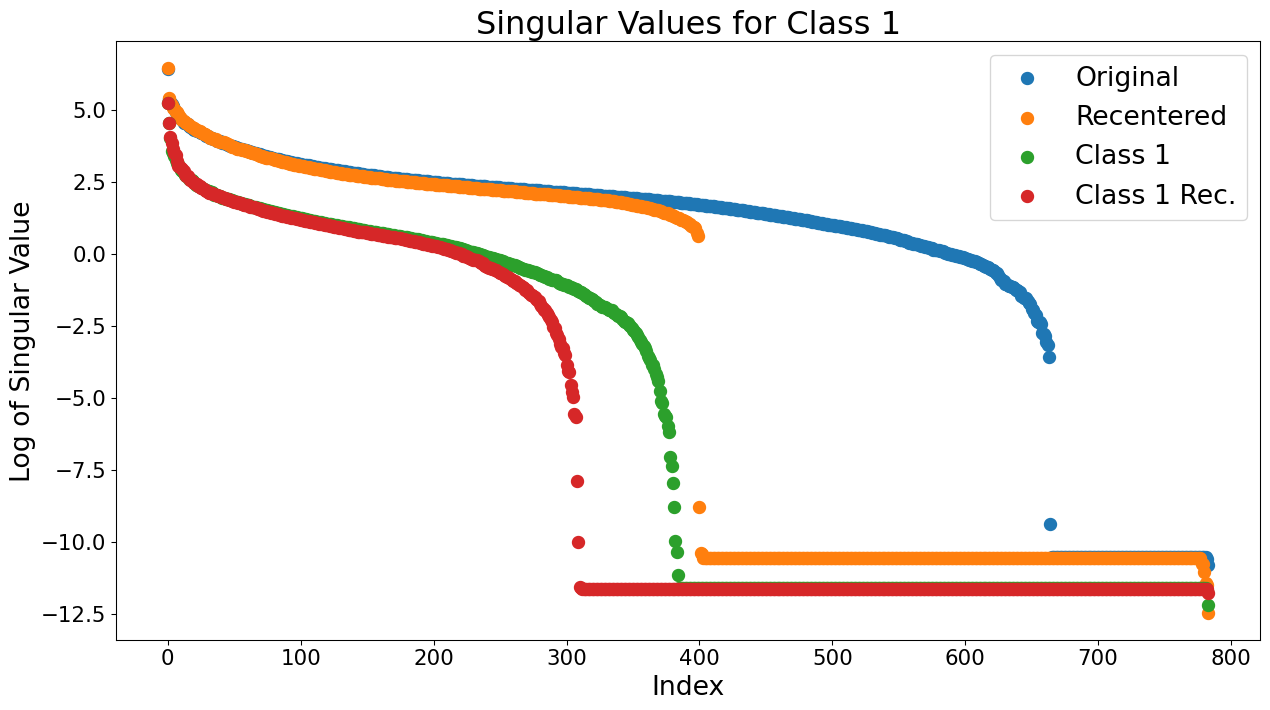

664 400 378 308


In [94]:
class_num = 1
plot_singular_values(
    s, s_rec, si_list[class_num], si_rec_list[class_num],
    labels=["Original", "Recentered", f"Class {class_num}", f"Class {class_num} Rec."],
    title=f"Singular Values for Class {class_num}",
    save=False,
    # figsize=(12,6)
)

find_cutoff = lambda arr: np.where(arr < 0.001)[0][0]
print(find_cutoff(s), find_cutoff(s_rec), find_cutoff(si_list[1]),find_cutoff(si_rec_list[1]))

In [ ]:
# fig, ax = plt.subplots(5, 2, figsize=(20,16))

# for i in range(5):
#     for j in range(2):
#         ax[i][j].scatter(np.arange(0,784), np.log(s))
#         ax[i][j].scatter(np.arange(0,784), np.log(si_list[i+5*j]))
#         ax[i][j].scatter(np.arange(0,784), np.log(si_rec_list[i+5*j]))
#         ax[i][j].set_title(f'Singular Values for Class {i+5*j}')

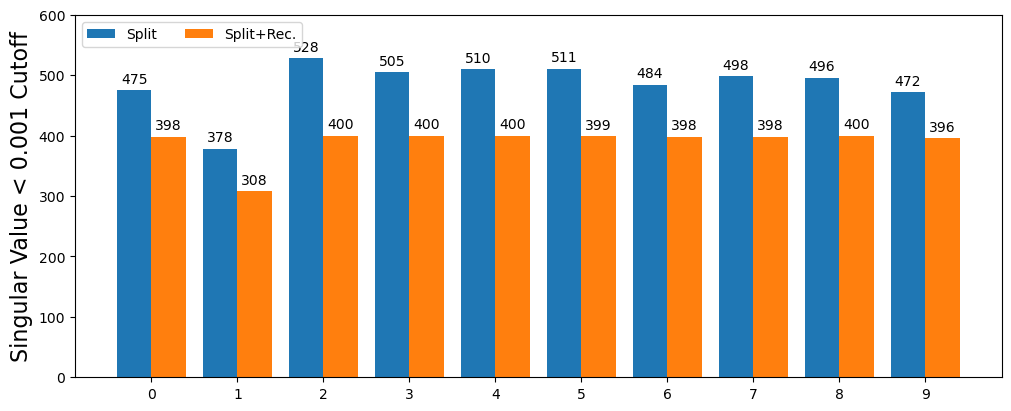

In [96]:
classes = [f'{i}' for i in range(10)]
cutoffs = {
    # 'Original': [find_cutoff(s) for i in range(10)],
    # 'Rec.': [find_cutoff(s_rec) for i in range(10)],
    'Split': [find_cutoff(si_list[i]) for i in range(10)],
    'Split+Rec.': [find_cutoff(si_rec_list[i]) for i in range(10)],
}

x = np.arange(len(classes))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,4))

for attribute, measurement in cutoffs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Singular Value < 0.001 Cutoff',fontsize=16)
ax.set_xticks(x + width/2, classes)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 600)

plt.show()